## Read Me Section

Created by - Samir Paul

ERA1 - Assignment for "Session 9 - Advanced Convolutions, Data Augmentation and Visualization "

Dataset = CIFAR10
Used Pytorch Framework

Objective
---------------
Write a new network that
has the architecture to C1C2C3C40 (No MaxPooling, but 3 convolutions, where the last one has a stride of 2 instead)

 (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then 200pts extra!)


total RF must be more than 44


one of the layers must use Depthwise Separable Convolution


one of the layers must use Dilated Convolution


use GAP (compulsory):- add FC after GAP to target #of classes (optional)


use albumentation library and apply:


horizontal flip
shiftScaleRotate
coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.

Work done and Results
---------------------
one of the layers must use Dilated Convolution

Albumentation is used

Parameters = 164,488

Created following individual modules for transformations, models, training code and test code and called these modules from main Python Notebook code.
  
  - mymodels.py
  - mytrain.py
  - mytest.py



At Epoch = 71, Test Accuracy  is 84.12%

## Perform standard imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

**Importing my Custom Library - Modular Code**

In [2]:
#import mydatatransformation as mytrsfm
#import myalbumentations as albutrsfm
import mymodels as mymodel
import mytrain
import mytest


In [3]:
import torchvision
import torch
import torchvision.transforms as transforms
# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):

    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

train_transforms = A.Compose(

    [

        A.HorizontalFlip(p=0.1),

        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=25, p=0.3),

        A.CoarseDropout(max_holes = 1, max_height=10, max_width=10, min_holes = 1, min_height=6, min_width=6,

                        fill_value=0.4734),

        A.Normalize(

            mean = (0.4914, 0.4822, 0.4465),

            std = (0.2470, 0.2435, 0.2616),

            p =1.0

        ),

        ToTensorV2()

    ],

    p=1.0

)


test_transforms = A.Compose(

    [

        #A.HorizontalFlip(p=0.5),

        #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),

        #A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,

                        #fill_value=0.4734),

        A.Normalize(

            mean = (0.4914, 0.4822, 0.4465),

            std = (0.2470, 0.2435, 0.2616),

            p =1.0

        ),

        ToTensorV2()

    ],

    p=1.0

)

In [4]:

train_data = Cifar10SearchDataset(root='./data', train=True,download=True, transform=train_transforms)
test_data = Cifar10SearchDataset(root='./data', train=False,download=True, transform=test_transforms)



100%|██████████| 170498071/170498071 [00:05<00:00, 29780588.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Lets view few images

Label: [    8     2     3     5     2     9     9     0     0     8     9     6
     2     2     5     6     8     4     7     9     7     7     5     3
     3     9     8     0     1     9     6     6     2     4     6     0
     4     9     1     1     7     3     4     8     9     0     6     8
     0     3     2     2     6     6     0     9     3     2     8     2
     2     4     2     6]
Class:   ship  bird   cat   dog  bird truck truck plane plane  ship truck  frog  bird  bird   dog  frog  ship  deer horse truck horse horse   dog   cat   cat truck  ship plane   car truck  frog  frog  bird  deer  frog plane  deer truck   car   car horse   cat  deer  ship truck plane  frog  ship plane   cat  bird  bird  frog  frog plane truck   cat  bird  ship  bird  bird  deer  bird  frog


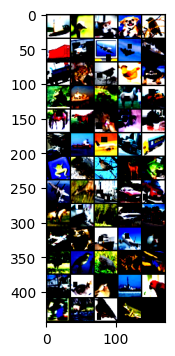

In [7]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))

# Grab the first batch of 10 images
for images,labels in train_loader:
    break
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))
im = make_grid(images, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [8]:
torch.manual_seed(101)
model = mymodel.Model_AdvConv_Albumentation()
model

Model_AdvConv_Albumentation(
  (convblock_C11): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01, inplace=False)
  )
  (convblock_C12): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.01, inplace=False)
  )
  (convblock_C13): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock_C21): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, 

In [9]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [10]:
print( '+++++++++++++++++++++++ Parameters for Batch Normalization Model +++++++++++++++++++++++++++++++++++'  )
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = mymodel.Model_AdvConv_Albumentation().to(device)
summary(model, input_size=(3, 32, 32))

+++++++++++++++++++++++ Parameters for Batch Normalization Model +++++++++++++++++++++++++++++++++++
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 30, 30]           1,152
              ReLU-6           [-1, 16, 30, 30]               0
       BatchNorm2d-7           [-1, 16, 30, 30]              32
           Dropout-8           [-1, 16, 30, 30]               0
            Conv2d-9           [-1, 32, 15, 15]           4,608
             ReLU-10           [-1, 32, 15, 15]               0
      BatchNorm2d-11           [-1, 32, 15, 15]              64
           Conv2d-12           [-1, 32, 15, 15]           9,2

In [11]:


!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = mymodel.Model_AdvConv_Albumentation().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4) # weight_decay=5e-4

In [12]:

EPOCHS = 85
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    criterion =  nn.CrossEntropyLoss()
    mytrain.train11(model, device, train_loader, optimizer, epoch, criterion)

    # scheduler.step()
    mytest.test11(model, device, test_loader)

EPOCH: 0


Loss=1.7655030488967896 Batch_id=781 Accuracy=40.21: 100%|██████████| 782/782 [00:24<00:00, 31.35it/s]



Test set:  Accuracy: 5088/10000 (50.88%)

EPOCH: 1


Loss=1.0996757745742798 Batch_id=781 Accuracy=54.91: 100%|██████████| 782/782 [00:19<00:00, 39.75it/s]



Test set:  Accuracy: 5954/10000 (59.54%)

EPOCH: 2


Loss=0.6951255798339844 Batch_id=781 Accuracy=60.94: 100%|██████████| 782/782 [00:17<00:00, 45.37it/s]



Test set:  Accuracy: 6598/10000 (65.98%)

EPOCH: 3


Loss=1.6785557270050049 Batch_id=781 Accuracy=64.87: 100%|██████████| 782/782 [00:17<00:00, 45.49it/s]



Test set:  Accuracy: 6867/10000 (68.67%)

EPOCH: 4


Loss=0.7246032953262329 Batch_id=781 Accuracy=67.59: 100%|██████████| 782/782 [00:18<00:00, 42.36it/s]



Test set:  Accuracy: 7180/10000 (71.80%)

EPOCH: 5


Loss=1.1170449256896973 Batch_id=781 Accuracy=69.96: 100%|██████████| 782/782 [00:17<00:00, 43.97it/s]



Test set:  Accuracy: 7342/10000 (73.42%)

EPOCH: 6


Loss=1.0916779041290283 Batch_id=781 Accuracy=71.14: 100%|██████████| 782/782 [00:17<00:00, 45.17it/s]



Test set:  Accuracy: 7403/10000 (74.03%)

EPOCH: 7


Loss=0.9061316251754761 Batch_id=781 Accuracy=72.52: 100%|██████████| 782/782 [00:18<00:00, 42.39it/s]



Test set:  Accuracy: 7621/10000 (76.21%)

EPOCH: 8


Loss=1.1277481317520142 Batch_id=781 Accuracy=73.68: 100%|██████████| 782/782 [00:18<00:00, 43.40it/s]



Test set:  Accuracy: 7500/10000 (75.00%)

EPOCH: 9


Loss=1.083043098449707 Batch_id=781 Accuracy=74.30: 100%|██████████| 782/782 [00:17<00:00, 45.23it/s]



Test set:  Accuracy: 7740/10000 (77.40%)

EPOCH: 10


Loss=1.087755560874939 Batch_id=781 Accuracy=75.03: 100%|██████████| 782/782 [00:17<00:00, 44.78it/s]



Test set:  Accuracy: 7752/10000 (77.52%)

EPOCH: 11


Loss=0.7712852358818054 Batch_id=781 Accuracy=75.91: 100%|██████████| 782/782 [00:17<00:00, 43.47it/s]



Test set:  Accuracy: 7771/10000 (77.71%)

EPOCH: 12


Loss=1.3665366172790527 Batch_id=781 Accuracy=76.57: 100%|██████████| 782/782 [00:17<00:00, 44.72it/s]



Test set:  Accuracy: 7829/10000 (78.29%)

EPOCH: 13


Loss=0.6327945590019226 Batch_id=781 Accuracy=77.14: 100%|██████████| 782/782 [00:17<00:00, 45.68it/s]



Test set:  Accuracy: 7880/10000 (78.80%)

EPOCH: 14


Loss=0.7877523303031921 Batch_id=781 Accuracy=77.51: 100%|██████████| 782/782 [00:17<00:00, 44.34it/s]



Test set:  Accuracy: 7848/10000 (78.48%)

EPOCH: 15


Loss=0.7953585982322693 Batch_id=781 Accuracy=78.00: 100%|██████████| 782/782 [00:18<00:00, 42.86it/s]



Test set:  Accuracy: 7994/10000 (79.94%)

EPOCH: 16


Loss=0.27152860164642334 Batch_id=781 Accuracy=78.05: 100%|██████████| 782/782 [00:18<00:00, 42.52it/s]



Test set:  Accuracy: 7987/10000 (79.87%)

EPOCH: 17


Loss=0.6937381029129028 Batch_id=781 Accuracy=78.79: 100%|██████████| 782/782 [00:17<00:00, 45.36it/s]



Test set:  Accuracy: 7838/10000 (78.38%)

EPOCH: 18


Loss=0.5713244676589966 Batch_id=781 Accuracy=78.80: 100%|██████████| 782/782 [00:17<00:00, 44.41it/s]



Test set:  Accuracy: 7987/10000 (79.87%)

EPOCH: 19


Loss=0.348727822303772 Batch_id=781 Accuracy=79.23: 100%|██████████| 782/782 [00:17<00:00, 45.74it/s]



Test set:  Accuracy: 8068/10000 (80.68%)

EPOCH: 20


Loss=1.0233181715011597 Batch_id=781 Accuracy=79.21: 100%|██████████| 782/782 [00:17<00:00, 45.01it/s]



Test set:  Accuracy: 8090/10000 (80.90%)

EPOCH: 21


Loss=0.49543941020965576 Batch_id=781 Accuracy=79.74: 100%|██████████| 782/782 [00:18<00:00, 43.22it/s]



Test set:  Accuracy: 8059/10000 (80.59%)

EPOCH: 22


Loss=0.7624979615211487 Batch_id=781 Accuracy=79.79: 100%|██████████| 782/782 [00:17<00:00, 44.88it/s]



Test set:  Accuracy: 8033/10000 (80.33%)

EPOCH: 23


Loss=0.8317175507545471 Batch_id=781 Accuracy=80.08: 100%|██████████| 782/782 [00:18<00:00, 43.27it/s]



Test set:  Accuracy: 8065/10000 (80.65%)

EPOCH: 24


Loss=0.42995601892471313 Batch_id=781 Accuracy=80.02: 100%|██████████| 782/782 [00:18<00:00, 41.99it/s]



Test set:  Accuracy: 8082/10000 (80.82%)

EPOCH: 25


Loss=0.45025238394737244 Batch_id=781 Accuracy=80.51: 100%|██████████| 782/782 [00:17<00:00, 45.01it/s]



Test set:  Accuracy: 8140/10000 (81.40%)

EPOCH: 26


Loss=0.38043713569641113 Batch_id=781 Accuracy=80.64: 100%|██████████| 782/782 [00:17<00:00, 44.28it/s]



Test set:  Accuracy: 8081/10000 (80.81%)

EPOCH: 27


Loss=0.4331219494342804 Batch_id=781 Accuracy=80.65: 100%|██████████| 782/782 [00:17<00:00, 44.52it/s]



Test set:  Accuracy: 8109/10000 (81.09%)

EPOCH: 28


Loss=0.689477264881134 Batch_id=781 Accuracy=80.69: 100%|██████████| 782/782 [00:18<00:00, 42.84it/s]



Test set:  Accuracy: 8110/10000 (81.10%)

EPOCH: 29


Loss=0.4779914617538452 Batch_id=781 Accuracy=81.19: 100%|██████████| 782/782 [00:17<00:00, 44.98it/s]



Test set:  Accuracy: 8144/10000 (81.44%)

EPOCH: 30


Loss=0.32397305965423584 Batch_id=781 Accuracy=81.31: 100%|██████████| 782/782 [00:18<00:00, 42.53it/s]



Test set:  Accuracy: 8119/10000 (81.19%)

EPOCH: 31


Loss=0.3293522596359253 Batch_id=781 Accuracy=81.33: 100%|██████████| 782/782 [00:17<00:00, 45.45it/s]



Test set:  Accuracy: 8183/10000 (81.83%)

EPOCH: 32


Loss=0.9301483631134033 Batch_id=781 Accuracy=81.52: 100%|██████████| 782/782 [00:18<00:00, 41.93it/s]



Test set:  Accuracy: 8139/10000 (81.39%)

EPOCH: 33


Loss=1.2555031776428223 Batch_id=781 Accuracy=81.61: 100%|██████████| 782/782 [00:18<00:00, 43.36it/s]



Test set:  Accuracy: 8239/10000 (82.39%)

EPOCH: 34


Loss=0.6178207993507385 Batch_id=781 Accuracy=81.55: 100%|██████████| 782/782 [00:17<00:00, 44.37it/s]



Test set:  Accuracy: 8133/10000 (81.33%)

EPOCH: 35


Loss=0.552230954170227 Batch_id=781 Accuracy=81.76: 100%|██████████| 782/782 [00:18<00:00, 42.17it/s]



Test set:  Accuracy: 8080/10000 (80.80%)

EPOCH: 36


Loss=0.5923909544944763 Batch_id=781 Accuracy=82.20: 100%|██████████| 782/782 [00:17<00:00, 44.52it/s]



Test set:  Accuracy: 8169/10000 (81.69%)

EPOCH: 37


Loss=0.3586396872997284 Batch_id=781 Accuracy=81.74: 100%|██████████| 782/782 [00:17<00:00, 45.00it/s]



Test set:  Accuracy: 8175/10000 (81.75%)

EPOCH: 38


Loss=0.6204197406768799 Batch_id=781 Accuracy=82.01: 100%|██████████| 782/782 [00:17<00:00, 44.37it/s]



Test set:  Accuracy: 8226/10000 (82.26%)

EPOCH: 39


Loss=0.14144429564476013 Batch_id=781 Accuracy=82.23: 100%|██████████| 782/782 [00:17<00:00, 44.93it/s]



Test set:  Accuracy: 8136/10000 (81.36%)

EPOCH: 40


Loss=0.3462767004966736 Batch_id=781 Accuracy=82.28: 100%|██████████| 782/782 [00:19<00:00, 39.51it/s]



Test set:  Accuracy: 8223/10000 (82.23%)

EPOCH: 41


Loss=0.37513893842697144 Batch_id=781 Accuracy=82.43: 100%|██████████| 782/782 [00:17<00:00, 45.06it/s]



Test set:  Accuracy: 8142/10000 (81.42%)

EPOCH: 42


Loss=0.3358747065067291 Batch_id=781 Accuracy=82.29: 100%|██████████| 782/782 [00:17<00:00, 44.75it/s]



Test set:  Accuracy: 8239/10000 (82.39%)

EPOCH: 43


Loss=0.33085858821868896 Batch_id=781 Accuracy=82.80: 100%|██████████| 782/782 [00:17<00:00, 45.42it/s]



Test set:  Accuracy: 8206/10000 (82.06%)

EPOCH: 44


Loss=0.514072835445404 Batch_id=781 Accuracy=82.32: 100%|██████████| 782/782 [00:17<00:00, 45.40it/s]



Test set:  Accuracy: 8249/10000 (82.49%)

EPOCH: 45


Loss=0.5186170339584351 Batch_id=781 Accuracy=82.89: 100%|██████████| 782/782 [00:18<00:00, 43.43it/s]



Test set:  Accuracy: 8222/10000 (82.22%)

EPOCH: 46


Loss=0.6462150812149048 Batch_id=781 Accuracy=82.84: 100%|██████████| 782/782 [00:17<00:00, 45.33it/s]



Test set:  Accuracy: 8237/10000 (82.37%)

EPOCH: 47


Loss=0.3773937225341797 Batch_id=781 Accuracy=83.16: 100%|██████████| 782/782 [00:18<00:00, 42.59it/s]



Test set:  Accuracy: 8198/10000 (81.98%)

EPOCH: 48


Loss=0.4021420180797577 Batch_id=781 Accuracy=83.05: 100%|██████████| 782/782 [00:18<00:00, 42.06it/s]



Test set:  Accuracy: 8244/10000 (82.44%)

EPOCH: 49


Loss=0.43701785802841187 Batch_id=781 Accuracy=82.71: 100%|██████████| 782/782 [00:17<00:00, 43.78it/s]



Test set:  Accuracy: 8330/10000 (83.30%)

EPOCH: 50


Loss=0.9928593635559082 Batch_id=781 Accuracy=83.07: 100%|██████████| 782/782 [00:17<00:00, 45.01it/s]



Test set:  Accuracy: 8330/10000 (83.30%)

EPOCH: 51


Loss=0.4986439049243927 Batch_id=781 Accuracy=83.14: 100%|██████████| 782/782 [00:17<00:00, 44.87it/s]



Test set:  Accuracy: 8318/10000 (83.18%)

EPOCH: 52


Loss=0.34785762429237366 Batch_id=781 Accuracy=83.10: 100%|██████████| 782/782 [00:18<00:00, 42.30it/s]



Test set:  Accuracy: 8365/10000 (83.65%)

EPOCH: 53


Loss=0.36111459136009216 Batch_id=781 Accuracy=83.07: 100%|██████████| 782/782 [00:17<00:00, 45.39it/s]



Test set:  Accuracy: 8212/10000 (82.12%)

EPOCH: 54


Loss=0.3200923502445221 Batch_id=781 Accuracy=83.35: 100%|██████████| 782/782 [00:17<00:00, 43.52it/s]



Test set:  Accuracy: 8284/10000 (82.84%)

EPOCH: 55


Loss=0.33579474687576294 Batch_id=781 Accuracy=83.35: 100%|██████████| 782/782 [00:17<00:00, 44.45it/s]



Test set:  Accuracy: 8249/10000 (82.49%)

EPOCH: 56


Loss=0.5229824781417847 Batch_id=781 Accuracy=83.63: 100%|██████████| 782/782 [00:17<00:00, 44.42it/s]



Test set:  Accuracy: 8277/10000 (82.77%)

EPOCH: 57


Loss=1.123740792274475 Batch_id=781 Accuracy=83.27: 100%|██████████| 782/782 [00:18<00:00, 42.13it/s]



Test set:  Accuracy: 8345/10000 (83.45%)

EPOCH: 58


Loss=0.34702515602111816 Batch_id=781 Accuracy=83.61: 100%|██████████| 782/782 [00:17<00:00, 44.62it/s]



Test set:  Accuracy: 8198/10000 (81.98%)

EPOCH: 59


Loss=0.18175528943538666 Batch_id=781 Accuracy=83.79: 100%|██████████| 782/782 [00:18<00:00, 42.98it/s]



Test set:  Accuracy: 8326/10000 (83.26%)

EPOCH: 60


Loss=0.27194586396217346 Batch_id=781 Accuracy=83.55: 100%|██████████| 782/782 [00:17<00:00, 44.18it/s]



Test set:  Accuracy: 8311/10000 (83.11%)

EPOCH: 61


Loss=0.6418106555938721 Batch_id=781 Accuracy=83.71: 100%|██████████| 782/782 [00:17<00:00, 43.48it/s]



Test set:  Accuracy: 8235/10000 (82.35%)

EPOCH: 62


Loss=0.9093282222747803 Batch_id=781 Accuracy=83.87: 100%|██████████| 782/782 [00:17<00:00, 44.93it/s]



Test set:  Accuracy: 8276/10000 (82.76%)

EPOCH: 63


Loss=0.42875099182128906 Batch_id=781 Accuracy=83.83: 100%|██████████| 782/782 [00:17<00:00, 43.86it/s]



Test set:  Accuracy: 8203/10000 (82.03%)

EPOCH: 64


Loss=0.6509523987770081 Batch_id=781 Accuracy=83.75: 100%|██████████| 782/782 [00:18<00:00, 42.15it/s]



Test set:  Accuracy: 8304/10000 (83.04%)

EPOCH: 65


Loss=0.7164835333824158 Batch_id=781 Accuracy=83.78: 100%|██████████| 782/782 [00:17<00:00, 43.65it/s]



Test set:  Accuracy: 8363/10000 (83.63%)

EPOCH: 66


Loss=0.4277897775173187 Batch_id=781 Accuracy=83.90: 100%|██████████| 782/782 [00:18<00:00, 41.88it/s]



Test set:  Accuracy: 8291/10000 (82.91%)

EPOCH: 67


Loss=0.681779146194458 Batch_id=781 Accuracy=84.01: 100%|██████████| 782/782 [00:17<00:00, 44.09it/s]



Test set:  Accuracy: 8322/10000 (83.22%)

EPOCH: 68


Loss=0.8551307916641235 Batch_id=781 Accuracy=83.97: 100%|██████████| 782/782 [00:18<00:00, 43.26it/s]



Test set:  Accuracy: 8273/10000 (82.73%)

EPOCH: 69


Loss=1.2159984111785889 Batch_id=781 Accuracy=83.88: 100%|██████████| 782/782 [00:17<00:00, 44.39it/s]



Test set:  Accuracy: 8356/10000 (83.56%)

EPOCH: 70


Loss=0.7325166463851929 Batch_id=781 Accuracy=83.94: 100%|██████████| 782/782 [00:17<00:00, 43.87it/s]



Test set:  Accuracy: 8318/10000 (83.18%)

EPOCH: 71


Loss=0.3588160276412964 Batch_id=781 Accuracy=83.93: 100%|██████████| 782/782 [00:18<00:00, 43.08it/s]



Test set:  Accuracy: 8412/10000 (84.12%)

EPOCH: 72


Loss=0.2907731235027313 Batch_id=781 Accuracy=84.11: 100%|██████████| 782/782 [00:18<00:00, 41.46it/s]



Test set:  Accuracy: 8111/10000 (81.11%)

EPOCH: 73


Loss=0.8499932885169983 Batch_id=781 Accuracy=84.12: 100%|██████████| 782/782 [00:18<00:00, 43.01it/s]



Test set:  Accuracy: 8269/10000 (82.69%)

EPOCH: 74


Loss=0.5915862917900085 Batch_id=781 Accuracy=84.23: 100%|██████████| 782/782 [00:17<00:00, 44.70it/s]



Test set:  Accuracy: 8174/10000 (81.74%)

EPOCH: 75


Loss=0.8823205828666687 Batch_id=781 Accuracy=84.07: 100%|██████████| 782/782 [00:19<00:00, 41.04it/s]



Test set:  Accuracy: 8311/10000 (83.11%)

EPOCH: 76


Loss=0.42963793873786926 Batch_id=781 Accuracy=84.37: 100%|██████████| 782/782 [00:17<00:00, 44.04it/s]



Test set:  Accuracy: 8355/10000 (83.55%)

EPOCH: 77


Loss=0.6268714666366577 Batch_id=781 Accuracy=84.21: 100%|██████████| 782/782 [00:17<00:00, 43.89it/s]



Test set:  Accuracy: 8283/10000 (82.83%)

EPOCH: 78


Loss=0.5042914152145386 Batch_id=781 Accuracy=84.09: 100%|██████████| 782/782 [00:17<00:00, 43.91it/s]



Test set:  Accuracy: 8353/10000 (83.53%)

EPOCH: 79


Loss=0.8660497069358826 Batch_id=781 Accuracy=84.10: 100%|██████████| 782/782 [00:17<00:00, 43.95it/s]



Test set:  Accuracy: 8359/10000 (83.59%)

EPOCH: 80


Loss=0.3747536242008209 Batch_id=781 Accuracy=84.61: 100%|██████████| 782/782 [00:19<00:00, 39.69it/s]



Test set:  Accuracy: 8397/10000 (83.97%)

EPOCH: 81


Loss=0.23491671681404114 Batch_id=781 Accuracy=84.47: 100%|██████████| 782/782 [00:18<00:00, 43.30it/s]



Test set:  Accuracy: 8333/10000 (83.33%)

EPOCH: 82


Loss=0.3297519385814667 Batch_id=781 Accuracy=84.64: 100%|██████████| 782/782 [00:18<00:00, 42.05it/s]



Test set:  Accuracy: 8351/10000 (83.51%)

EPOCH: 83


Loss=0.4834408164024353 Batch_id=781 Accuracy=84.40: 100%|██████████| 782/782 [00:17<00:00, 43.77it/s]



Test set:  Accuracy: 8334/10000 (83.34%)

EPOCH: 84


Loss=0.286406010389328 Batch_id=781 Accuracy=84.58: 100%|██████████| 782/782 [00:17<00:00, 43.46it/s]



Test set:  Accuracy: 8309/10000 (83.09%)

